In [1]:
import pandas as pd
import random
import math
import numpy as np
import scipy.sparse.linalg
import matplotlib.pyplot as plt
import sklearn.metrics

#Ease of Life libraries used to simulate progression of slow algorithms
from ipywidgets import IntProgress
from IPython.display import display
import time

In [2]:
#Load the data as given.
data = pd.read_csv("phily_users_businesses_stars.csv", encoding="latin")

print(data.info()) #Info regarding the Businesses. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967552 entries, 0 to 967551
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      967552 non-null  object 
 1   business_id  967552 non-null  object 
 2   stars        967552 non-null  float64
dtypes: float64(1), object(2)
memory usage: 22.1+ MB
None


# Step 1: Data Pruning
Starting things off, we load our data as given, and proceed to trim it down with the following steps:
1. We remove all Users that have not made more than 15 reviews in total.
2. We remove all Businesses that do not have more than 15 reviews.
3. If our data has changed since Step 1, go back to step 1. Otherwise, exit.

Via this iterative process we prune our data down to 302141 pairs of 6961 Users and 4064 Businesses!

In [3]:
#STEP 1
prevLen = -1
currentLen = len(data)
newData = data.copy()

#Iterate the copied data. If after the iteration the size is the same, stop. otherwise, repeat.
while prevLen != currentLen:
    print("Current Data Size: ", len(newData))
    
    #Prune Non-Active Users.
    activeUsers = newData.groupby(["user_id"]).count()
    activeUsers = activeUsers.loc[activeUsers["business_id"] > 15].reset_index()
    newData = newData.loc[data["user_id"].isin(activeUsers["user_id"].unique())]

    #Prune Non-Active Businesses.
    activeBusinesses = newData.groupby(["business_id"]).count()
    activeBusinesses = activeBusinesses.loc[activeBusinesses["user_id"] > 15].reset_index()
    newData = newData.loc[data["business_id"].isin(activeBusinesses["business_id"].unique())]
    
    prevLen = currentLen
    currentLen = len(newData)
print("\nTotal Unique Users: ", len(newData["user_id"].unique()))
print("Total Unique Businesses: ", len(newData["business_id"].unique()))
print("Total Size: ", len(newData))

Current Data Size:  967552
Current Data Size:  328838
Current Data Size:  304657
Current Data Size:  302440
Current Data Size:  302156
Current Data Size:  302141

Total Unique Users:  6961
Total Unique Businesses:  4064
Total Size:  302141


# Step 2: Train and Test Data
Using Pandas' sample function we can pick out roughly 30k of our data for testing, while keeping the rest for training on the following algorithms. While this is done, for the purpose of this exercise, we ignore our sampled objects and instead use the ones given.

### **Note** 
The variables defined as testData and trainData are the original samples. Further down, variables defined as testingData and trainingData are copies of the original samples. This is done to make it easier to showcase the results of several algorithms.

In [4]:
#STEP 2
#Test Size: 30210 (~10%)
workData = newData.copy()
#Our Testing Data, sampled from original data.
testData = workData.sample(n=30210)
#Our train data, being our original data minus the test data.
trainData = workData.loc[workData.index.difference(testData.index)]

print("Train Data Length: ", len(trainData))
print("Test Data Length: ", len(testData))



#Now to actually load them.
trainData = pd.read_csv("phily_users_businesses_stars_train.csv", encoding="latin")
testData = pd.read_csv("phily_users_businesses_stars_test.csv", encoding="latin")
newData = trainData.append(testData)

Train Data Length:  271931
Test Data Length:  30210


# Step 3: Mean Stars Algorithm
A rather simplistic but easy approach. We start by grouping the data by each user, and calculate their mean value accordingly. We then make this mean number our guess for each testing data sample.
This process is done for each Business as well, for a different iteration.

The final results seem suprisingly promision, with both algorithms averaging a 1.03 RMSE! By no means is this perfect, but a perfectly acceptable result for such a simple method. We notice that the Business Average algorithm has a lower RMSE when compared to the User one; which makes sense, since the average business score is the one closest to most invidisual review scores.

In [11]:
#STEP 3
#First, find the mean value of each business/user accordingly
userMean = trainData.groupby(["user_id"]).mean().reset_index()
businessMean = trainData.groupby(["business_id"]).mean().reset_index()

#Starting with the User Mean we merge the testing Data with our user Mean by user..
testingData = testData.copy().rename({"stars":"trueStars"}, axis=1)
testingData = testingData.merge(userMean, how="left", left_on="user_id", right_on="user_id").dropna()
#And using the trueStars (actual value) and the stars (guess value/mean) we find the RMSE
RMSE = math.sqrt(sum((testingData["trueStars"]-testingData["stars"])**2)/len(testingData))
print("RMSE of User Mean = ", RMSE)

#The same procedure is done with business mean
testingData = testData.copy().rename({"stars":"trueStars"}, axis=1)
testingData = testingData.merge(businessMean, how="left", left_on="business_id", right_on="business_id").dropna()

RMSE = math.sqrt(sum((testingData["trueStars"]-testingData["stars"])**2)/len(testingData))
print("RMSE of Business Mean = ", RMSE)

RMSE of User Mean =  1.0474294959962005
RMSE of Business Mean =  1.0055572526079652


# Step 4: Singular Value Decomposition - k-Rank
SVD breaks down our matrix into more major components, which in return can be shortened to keep only important data in our memory. This way, the algorithm is faster, more memory efficient but of course greedier.
- First, we map each UserID and BusinessID to a corresponding number. We keep this dictionary for later uses and overall steps.
- We drop all duplicates before constructing the Sparse Matrix R.

**Note: This is done automatically by the scipy.sparse.csr_matrix function, but we chose to do it beforehand regardless.**
- Using the scipy's SVDS function, we break the Sparse Matrix R into our U and VH matrix, as well as the S vector.
- Afterwards, for K = [1,100] we calculate for each Test Sample the estimate, using the given formula. K represents the rank of used elements from each matrix. The higher the K, the more information is kept and thus the better the result should be, in exchange for computational power.


In [8]:
#Step 4:
trainingData = trainData.reset_index().drop(["index"],axis=1)

#Find all Unique appearances of Users and Businesses
uniqueUsers = newData["user_id"].unique()
uniqueBusinesses = newData["business_id"].unique()
#Map them
uniqueUsers = {uniqueUsers[i]:i for i in range(len(uniqueUsers))}
uniqueBusinesses = {uniqueBusinesses[i]:i for i in range(len(uniqueBusinesses))}
#Use generated maps to convert to their IDs
trainingData["user_id"] = trainingData["user_id"].apply(lambda x : uniqueUsers[x])
trainingData["business_id"] = trainingData["business_id"].apply(lambda x : uniqueBusinesses[x])
#For the purposes of Sparse Matrix, we drop all duplicate user_id,business_id pairs
trainingData = trainingData.drop_duplicates(subset=["user_id","business_id"])


#Same proceure for our test data
testingData = testData.copy()
testingData["user_id"] = testingData["user_id"].apply(lambda x : uniqueUsers[x])
testingData["business_id"] = testingData["business_id"].apply(lambda x : uniqueBusinesses[x])
testingData = testingData.drop_duplicates(subset=["user_id","business_id"])

R = scipy.sparse.csr_matrix((trainingData["stars"], (trainingData["user_id"], trainingData["business_id"])),
                                     shape=(len(uniqueUsers), len(uniqueBusinesses)))


u, s, vh = scipy.sparse.linalg.svds(R, k=100)



# Step 4: Results
As expected, we see a great decrease as the K value increases. We see the lowest value at K=100.
Should be noted that the overall RMSE is very high, making this algorithm worse the the User/Business Average one. The complexity is also pretty high due to the cost of matrix multiplication. Overall, the results are not satisfactory.

IntProgress(value=0)

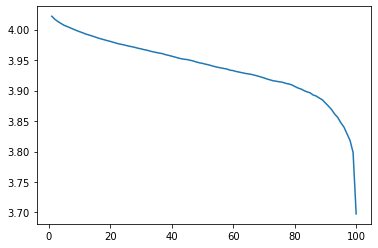

In [14]:
loadingBar = IntProgress(min=0, max=100) # instantiate the bar
display(loadingBar) # display the bar

errors = []
roundTestData = testingData.copy()
for k in range(1,101):
    
    roundTestData["guess"] = roundTestData.apply(lambda x : u[int(x.user_id),:][:k]@
                                                            np.diag(s[:k])@
                                                            vh[:,int(x.business_id)].T[:k] , axis=1)
    
    roundTestData["guess"] = roundTestData["guess"].apply(lambda x: 5 if x > 5 else x)
    roundTestData["guess"] = roundTestData["guess"].apply(lambda x: 0 if x < 0 else x)
    
    
    RMSE = sklearn.metrics.mean_squared_error(roundTestData["stars"], roundTestData["guess"], squared=False)
    errors.append(RMSE)
    loadingBar.value += 1
null=plt.plot([k for k in range(1,101)], errors)

# Step 5,6: Collaborative Filtering
A similar process of preparing the needed data is executed on the code bellow, as we once more map our IDs to numbers and transform their new values (Stars - Average Stars) into a new sparse matrix.

**Note: Due to the difficulty of those steps, several attempts were made, yielding different results. We 2 of the best attempts of those algorithms. While the results are similar, the code and method are different, thus resulting in different execution times.**

In [87]:
#Prepare Sparse Matrix
trainingData = trainData.reset_index().drop(["index"],axis=1)
#Find all Unique appearances of Users and Businesses
uniqueUsers = trainingData["user_id"].unique()
uniqueBusinesses = trainingData["business_id"].unique()
#Map them
uniqueUsers = {uniqueUsers[i]:i for i in range(len(uniqueUsers))}
uniqueBusinesses = {uniqueBusinesses[i]:i for i in range(len(uniqueBusinesses))}
#Use generated maps to convert to their IDs
trainingData["user_id"] = trainingData["user_id"].apply(lambda x : uniqueUsers[x])
trainingData["business_id"] = trainingData["business_id"].apply(lambda x : uniqueBusinesses[x])

#Prepare Data Values
userMean = trainData.groupby(["user_id"]).mean().reset_index()
userMean["user_id"] = userMean["user_id"].apply(lambda x : uniqueUsers[x])
trainingData = trainingData.merge(userMean.rename({"stars":"meanStars"}, axis=1),
                                   how="left", left_on="user_id", right_on="user_id")
trainingData["value"] = trainingData["stars"] - trainingData["meanStars"]


R = scipy.sparse.csr_matrix((trainingData["value"], (trainingData["user_id"], trainingData["business_id"])),
                                     shape=(len(uniqueUsers), len(uniqueBusinesses)))


#Same Procedure for our test data
testingData = testData.copy()
testingData["user_id"] = testingData["user_id"].apply(lambda x : uniqueUsers[x])
testingData["business_id"] = testingData["business_id"].apply(lambda x : uniqueBusinesses[x])

# Step 5: Collaborative Filtering - Users
After preparing the sparse matrix R, we calculate the similarities between ALL USERS. This is done using the pairwise_cosine_similarity function. This cuts a lot of the execution time, so that the algorithm runs at greater efficiency. Having that calculated, we apply our new function to all pairs within our TestinData:
- We check if the User's Sparse Matrix Row is all zeros. If so, return the mean value for all values of K.
- If not, we find Users that have reviewd the current business. This is done by finding all Users with a nonzero value in the sparse matrix, and saving them as "businessUsers'.
- We then use them to get their similarities with our original user (uid).
- Having all the needed data, we then calculate the estimate using the given formula for all values of K. If there are less than K users, we use them all.
- We clip all predictions within the values of 0 and 5.

# Conclusion
The overall complexity is rather high. The algorithm manages to find all needed estimates in roughly 1 minute per K value (total time ~10-12 minutes!). The results however are very close to that of our currently best algorithm (Business Average). We see the overall RMSE reach its minimum value for K=15 with roughly 1.042 RMSE. The error lowers up to K=25 and afterwards ascends slowly. We imagine this to be due to the amount of negative similarities. When increasing the K value to greater values, we start to include Users that have negative similarity, and thus affect the estimation in the wrong direction, giving worse results.


IntProgress(value=0, max=30214)

Best K= 15  with RMSE= 1.042


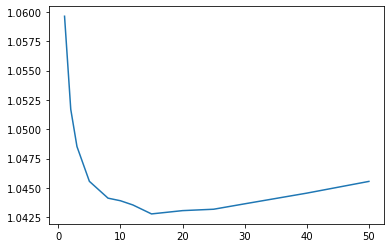

In [28]:
#Step 5
loadingBar = IntProgress(min=0, max=len(testingData)) 
display(loadingBar) 

def findUCFScore(uid, bid):
    loadingBar.value += 1
        
    if not np.any(R[uid].toarray()[0]):
        avg = userMean.loc[userMean["user_id"] == uid].values[0][1]
        return np.array([avg]*13)
    
    businessUsers = R[:,bid].nonzero()[0]

    similarities = pd.DataFrame(similarityMatrix[uid].take(businessUsers)).reset_index().rename({"index":"user_id",
                                                                                                 0:"similarity"}, axis=1)
    similarUsers = similarities.sort_values(["similarity"], ascending=False)

    scores = []
    score = 0
    
    
    for k in [1,2,3,5,8,10,12,15,20,25,30,40,50]:
        score = userMean.loc[userMean["user_id"] == uid].to_numpy()[0][1]
        
        mostSimilarUsers = similarUsers
        if len(similarUsers) > k:
            mostSimilarUsers = mostSimilarUsers[:k]
        
        #Similar Users can be 0.
        divided = mostSimilarUsers["similarity"]*np.take(R[:,bid].toarray(), mostSimilarUsers.index, axis=0).flatten()

        divided = sum(divided)
        divisor = sum(mostSimilarUsers["similarity"])
        
        #In case the K most similar users are exactly the same as the original user.
        if divisor != 0:
            score += divided/divisor
        
        score = 5 if score > 5 else score
        score = 0 if score < 0 else score     
        scores.append(score)
    return scores

similarityMatrix = sklearn.metrics.pairwise.cosine_similarity(R)
testingData["k"] = testingData.apply(lambda x : findUCFScore(int(x.user_id), int(x.business_id)), axis=1)

K = [1,2,3,5,8,10,12,15,20,25,30,40,50]
Y = []
for i in range(13):
    scoreData = testingData.copy()
    scoreData["score"] = scoreData.apply(lambda x :(x.stars-x.k[i])**2, axis=1)
    
    Y.append(math.sqrt(sum(scoreData["score"])/len(scoreData)))
    
null = plt.plot(K, Y)
print("Best K=", K[np.argmin(Y)], " with RMSE=", str(min(Y))[:5])

# Step 6: Collaborative Filtering - Items
The process is the same as Step 5 but using the businesses as our means of comparison. We calculate the Transposed Sparse Matrix of R (RT), which we use to fetch Businesses more easily, as well as to calculate the similarity matrix between them.

# Conclusion
The complexity follows the same path as the UCF algorithm, running for roughly 10-12m. As for the overall results, they are similar as UCF but slightly worse. For K=10 we get the best RMSE for 1.051. Afterwards however, the function escalates very fast, even surpassing the initial RMSE for K=1! This concludes that overall the ICF algorithm is not ideal.

IntProgress(value=0, max=30214)

Best K= 12  with RMSE= 1.052


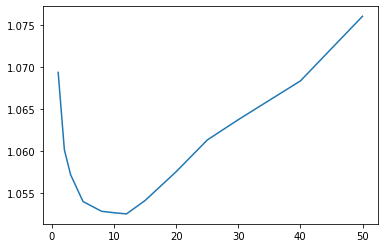

In [29]:
#Step 6
loadingBar = IntProgress(min=0, max=len(testingData)) 
display(loadingBar) 

def findUCFScore(uid, bid):
    global RT

    loadingBar.value += 1
        
    if not np.any(RT[bid].toarray()[0]):
        return [userMean.loc[userMean["user_id"] == uid].to_numpy()[0][1]]*13
    
    usersBusinesses = R[uid,:].nonzero()[1]

    similarities = pd.DataFrame(similarityMatrix[bid].take(usersBusinesses)).reset_index().rename({"index":"user_id",
                                                                                                 0:"similarity"}, axis=1)
    similarBusinesses = similarities.sort_values(["similarity"], ascending=False)
    
    scores = []
    score = 0
    
    
    for k in [1,2,3,5,8,10,12,15,20,25,30,40,50]:
        score = userMean.loc[userMean["user_id"] == uid].to_numpy()[0][1]
        
        mostSimilarBusinesses = similarBusinesses
        if len(similarBusinesses) > k:
            mostSimilarBusinesses = similarBusinesses[:k]

        #Similar Users can be 0.
        divided = mostSimilarBusinesses["similarity"]*np.take(R[uid].toarray()[0], mostSimilarBusinesses.index, axis=0).flatten()
        divided = sum(divided)
        divisor = sum(mostSimilarBusinesses["similarity"])
        
        #In case the K most similar users are exactly the same as the original user.
        if divisor != 0:
            score += divided/divisor
        
        score = 5 if score > 5 else score
        score = 0 if score < 0 else score     
        scores.append(score)
    return scores

#Transpose of R to get Business Similarity
RT = R.T
similarityMatrix = sklearn.metrics.pairwise.cosine_similarity(RT)
testingData["k"] = testingData.apply(lambda x : findUCFScore(int(x.user_id), int(x.business_id)), axis=1)

K = [1,2,3,5,8,10,12,15,20,25,30,40,50]
Y = []
for i in range(13):
    scoreData = testingData.copy()
    scoreData["score"] = scoreData.apply(lambda x :(x.stars-x.k[i])**2, axis=1)
    
    Y.append(math.sqrt(sum(scoreData["score"])/len(scoreData)))
    
null = plt.plot(K, Y)
print("Best K=", K[np.argmin(Y)], " with RMSE=", str(min(Y))[:5])

# UCF - A Second Approach
With the time complexity reaching an all-time high, a different approach was implemented. By calculating the needed values before running through the testing data, we manage to get a total time of roughly 7 minutes of execution. This include the initial set up that follows.

1. For each user in our test data we calculate the similarity of each user in the training data.
2. We then find all users that reviewed each business from our training data.
3. We cross-reference the two datasets to find the most similar users that reviewed each business for each pair in our test data.

## Conclusion
Having all that calculated (1m of execution time) the iterative process is done way faster (5-6m). As for the result, while the function follows a similar pattern, the result improves with RMSE of 1.024 for K=10.

In [88]:
loadingBar = IntProgress(min=0, max=(len(testingData)/5)+100) 
display(loadingBar) 

index = -1
def getUsefulUsers(uid, bid):
    global index
    index += 1
    
    if index % 5 == 0:
        loadingBar.value += 1
    
    mostSimilarUsers = similarUsers[index]
    reviewers = businessUsers[bid]
    return mostSimilarUsers[ np.in1d(mostSimilarUsers, reviewers)]

similarityMatrix = sklearn.metrics.pairwise.cosine_similarity(R)
loadingBar.value += 50
similarUsers = testingData["user_id"].apply(lambda x : np.flip(similarityMatrix[x].argsort()))
loadingBar.value += 50
businessUsers = trainingData.groupby(["business_id"])["user_id"].apply(list)

uniqueTestPairs = testingData.copy()
uniqueTestPairs["usefulUsers"] = uniqueTestPairs.apply(lambda x : getUsefulUsers(x.user_id, x.business_id), axis=1)


IntProgress(value=0, max=6142)

IntProgress(value=0, max=30214)

Best K= 10  with RMSE= 1.024


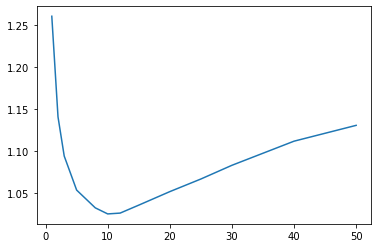

In [89]:
K = [1,2,3,5,8,10,12,15,20,25,30,40,50]
loadingBar = IntProgress(min=0, max=len(testingData)) 
display(loadingBar) 

index = -1
kScores = []
for uid, bid in zip(testingData["user_id"], testingData["business_id"]):
    
    scores = []
    
    index += 1
    loadingBar.value += 1
    
    r = userMean.loc[userMean["user_id"] == uid]["stars"].values[0]

    usefulUsers = uniqueTestPairs.iloc[index]["usefulUsers"]
        
    for k in K:
        currentSample = usefulUsers
        if k <= len(usefulUsers):
            currentSample = usefulUsers[:k]

        similarityVector = similarityMatrix[uid, currentSample]

        divisor = sum(similarityVector)

        if divisor == 0:
            scores.append(r)
            continue

        divided = sum([similarityVector[i]*R[currentSample[i], bid] for i in range(len(currentSample))])
        score = (divided/divisor)+r
        if score > 5:
            score = 5
        elif score < 0:
            score = 0 
        scores.append(score)
    kScores.append(scores)
testingData["k"] = kScores

Y = []
for i in range(len(K)):
    scoreData = testingData.copy()
    scoreData["score"] = scoreData.apply(lambda x :(x.stars-x.k[i])**2, axis=1)
    
    Y.append(math.sqrt(sum(scoreData["score"])/len(scoreData)))
    
null = plt.plot(K, Y)
print("Best K=", K[np.argmin(Y)], " with RMSE=", str(min(Y))[:5])

# ICF - Second Approach
Similarly to UCF, the algorithm is improved, with the aproximate time being roughly 6-7 minutes. The function has not improved however, witht he ascent being more rapid and reaching an all time peak for all attempts. The best score is 1.092 for K=8, which is not an improvement when compared to the original attempt.

In [82]:
loadingBar = IntProgress(min=0, max=(len(testingData)/5)+100) 
display(loadingBar) 

index = -1
def getUsefulUsers(uid, bid):
    global index
    global similarityMatrix
    global similarBusinesses
    global usersBusinesses
    
    index += 1
    if index % 5 == 0:
        loadingBar.value += 1
    
    mostSimilarBusinesses = similarBusinesses[index]
    reviewed = usersBusinesses[uid]
    return mostSimilarBusinesses[ np.in1d(mostSimilarBusinesses, reviewed)]

RT = R.T
similarityMatrix = sklearn.metrics.pairwise.cosine_similarity(RT)
loadingBar.value += 50
usersBusinesses = trainingData.groupby(["user_id"])["business_id"].apply(list)
similarBusinesses = testingData["business_id"].apply(lambda x : np.flip(similarityMatrix[x].argsort()))

uniqueTestPairs = testingData.copy()
uniqueTestPairs["usefulBusinesses"] = uniqueTestPairs.apply(lambda x : getUsefulUsers(x.user_id, x.business_id), axis=1)

IntProgress(value=0, max=6142)

IntProgress(value=0, max=30214)

Best K= 8  with RMSE= 1.092


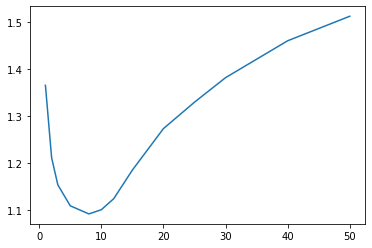

In [83]:
K = [1,2,3,5,8,10,12,15,20,25,30,40,50]
loadingBar = IntProgress(min=0, max=len(testingData)) 
display(loadingBar) 

index = -1
kScores = []
for uid, bid in zip(testingData["user_id"], testingData["business_id"]):
    
    scores = []
    
    index += 1
    loadingBar.value += 1
    
    r = userMean.loc[userMean["user_id"] == uid]["stars"].values[0]

    usefulBusinesses = uniqueTestPairs.iloc[index]["usefulBusinesses"]
        
    for k in K:
        currentSample = usefulBusinesses
        if k <= len(usefulUsers):
            currentSample = usefulBusinesses[:k]

        similarityVector = similarityMatrix[bid, currentSample]

        divisor = sum(similarityVector)

        if divisor == 0:
            scores.append(r)
            continue

        divided = sum([similarityVector[i]*R[uid, currentSample[i]] for i in range(len(currentSample))])
        score = (divided/divisor)+r
        if score > 5:
            score = 5
        elif score < 0:
            score = 0 
        scores.append(score)
    kScores.append(scores)
testingData["k"] = kScores

Y = []
for i in range(len(K)):
    scoreData = testingData.copy()
    scoreData["score"] = scoreData.apply(lambda x :(x.stars-x.k[i])**2, axis=1)
    
    Y.append(math.sqrt(sum(scoreData["score"])/len(scoreData)))
    
null = plt.plot(K, Y)
print("Best K=", K[np.argmin(Y)], " with RMSE=", str(min(Y))[:5])

# Step 7: Final Conclusions

Having tested several algorithms to approximate the star values of our testing data, we have concluded to the following:

| <div style="width:300px">Algorithm</div>     | <div style="width:300px">RMSE</div> | <div style="width:300px">Execution Time</div>     |
| :---:       |    :----:   |         :---: |
| Business Average   | 1.005        | <1s      |
| UCF   | 1.024       | ~6m      |
| User Average      | 1.047       | <1s   |
| ICF   | 1.052        | ~10m      |
| SVD   | 3.7        | ~1m      |

Overall, for the given data, Business Average provides the overall best RMSE **and** execution speed. Close seconds are UCF and ICF, as well as the UA algorithms. SVD on the other hand has the worst score of all 5 for values of K up to 100. Having those in mind we can conclude:

- BA and UA are the fastest. Their scores are ideal and despite their small complexity, they surpass all algorithms that we tried for the current dataset.
- UCF and ICF provide very good results, but their complexity renders them slow. Having tried 2 different approaches on both algorithms, we notice a strange randomness on their results. While the process should be identical, their results are not. On a previous attempt, we recreated manually the sparse matrix R to test a theory, and the results improved slightly. With that in mind, we theorize that the Scipy.CSR_Matrix could have a randomness factor of choosing that we did not account for. As a final note, we conclude that for higher K values, the score increases drastically, proving that when adding many users/businesses with low and/or negative similarity, the overall accuracy decreases.
- SVD proves the worse of all results, and while the time complexity is relatively low, the score does not prove fruitful. A note to be made is that the slope of its RMSE seems to drop very quickly for high K values, therefore it's possible for  K > 100 to improve the score.